In [1]:
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from scipy.stats import norm, pearsonr
import plotly.express as px
from sklearn.metrics import accuracy_score,  cohen_kappa_score 

C:\Users\jichen\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#pip install --upgrade --user pandas

In [3]:
import sklearn
sklearn.__version__

'1.3.0'

In [4]:
def generate_discrete_data(rho,n,ptile1,ptile2,ptile3):
    mean = (0, 0)
    cov = [[1, rho], [rho, 1]]
    v = np.random.multivariate_normal(mean, cov, (n))
    x = v[:,0]
    y = v[:,1]
    x_cut1 = np.percentile(x,ptile1)
    x_cut2 = np.percentile(x,ptile2)
    x_cut3 = np.percentile(x,ptile3)
    x[x < x_cut1]=1
    x[(x >= x_cut1)*(x < x_cut2)*(x !=1)] = 2
    x[(x >= x_cut2)*(x < x_cut3)*(x !=1)*(x !=2)] = 3
    x[(x >= x_cut3)*(x !=1)*(x !=2)*(x!=3)] = 4
    
    rho_out = pearsonr(x,y)[0] 
    df = pd.DataFrame([x,y]).T
    df.columns=['ALDs','difficulty_parameter']
    fig = px.scatter(df,x='ALDs',y='difficulty_parameter',marginal_y='histogram',color='ALDs'\
                   ,trendline='ols',title='Correlation: '+str(rho_out)[0:4])
    fig.update_layout(width=800, height=500)
    # fig.show()
    # print(df.ALDs.value_counts())
    return df

In [5]:
df = generate_discrete_data(0.8,1000,40, 80, 90)

In [6]:
df.head(2)

,ALDs,difficulty_parameter
0,1.0,-0.778239
1,4.0,1.405705


In [101]:
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score
level_number = '34'
ptile = 75
data = df.copy()

data.loc[data.ALDs ==1, 'ALD12'] = 'low' # recode ALDs to low or high for each ALD cut
data.loc[data.ALDs > 1, 'ALD12'] = 'high'
data.loc[data.ALDs <=2, 'ALD23'] = 'low'
data.loc[data.ALDs > 2, 'ALD23'] = 'high'
data.loc[data.ALDs <=3, 'ALD34'] = 'low'
data.loc[data.ALDs > 3, 'ALD34'] = 'high'

y = data['ALD'+level_number]

# Calculate ROC curve and AUC for different cutoffs
fpr, tpr, thresholds = roc_curve(y, data['difficulty_parameter'], pos_label='high')

# Calculate Youden's J statistic for each threshold
youden_index = tpr - fpr

# Find the optimal threshold based on maximizing Youden's J statistic
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_threshold_index]


# Create an empty array to store predicted labels
y_pred_labels = []

# Assign labels based on the threshold
for threshold in thresholds:
    y_pred = np.where(data['difficulty_parameter'] >= threshold, 'high', 'low')
    y_pred_labels.append(y_pred)

# Find the threshold that maximizes accuracy
accuracies = [accuracy_score(y, y_pred) for y_pred in y_pred_labels]
max_accuracy_index = np.argmax(accuracies)
optimal_accuracy_threshold = thresholds[max_accuracy_index]

# Print the optimal thresholds
print("Optimal Threshold (Youden's J):", optimal_threshold)
print("Optimal Threshold (Max Accuracy):", optimal_accuracy_threshold)

Optimal Threshold (Youden's J): 0.5051168587549894
Optimal Threshold (Max Accuracy): 1.461356610144272


In [97]:
y_pred

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: difficulty_parameter, Length: 1000, dtype: int32

# ROC

In [7]:
def optimal_cut_roc (data,level_number):# ptile is the percentile for the distribution,
    # e.g. ptile = 25 for the first cut of the uniform distribution
    # e.g. level_number = '12' for the first cut of the distribution
    data.loc[data.ALDs ==1, 'ALD12'] = 'low' # recode ALDs to low or high for each ALD cut
    data.loc[data.ALDs > 1, 'ALD12'] = 'high'
    data.loc[data.ALDs <=2, 'ALD23'] = 'low'
    data.loc[data.ALDs > 2, 'ALD23'] = 'high'
    data.loc[data.ALDs <=3, 'ALD34'] = 'low'
    data.loc[data.ALDs > 3, 'ALD34'] = 'high'
    
    y = data['ALD'+level_number]

    # Calculate ROC curve and AUC for different cutoffs
    fpr, tpr, thresholds = roc_curve(y, data['difficulty_parameter'], pos_label='high')
    
    roc_auc = auc(fpr, tpr)

    # Find the optimal cutoff based on maximizing AUC
    optimal_cutoff_index = np.argmax(tpr - fpr)
    optimal_cutoff = thresholds[optimal_cutoff_index]
    optimal_cutoff = round(optimal_cutoff,2)
    
    # Create an empty array to store predicted labels
    y_pred_labels = []

    # Assign labels based on the threshold
    for threshold in thresholds:
        y_pred = np.where(data['difficulty_parameter'] >= threshold, 'high', 'low')
        y_pred_labels.append(y_pred)

    # Find the threshold that maximizes accuracy
    accuracies = [accuracy_score(y, y_pred) for y_pred in y_pred_labels]
    max_accuracy_index = np.argmax(accuracies)
    optimal_accuracy_threshold = thresholds[max_accuracy_index]

    return (optimal_cutoff, optimal_accuracy_threshold)

In [8]:
optimal_cut_roc(df,'12')

-0.1

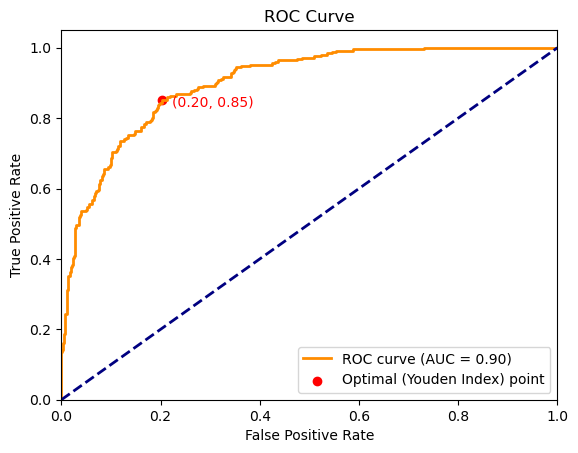

In [54]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.scatter(fpr[optimal_cutoff_index], tpr[optimal_cutoff_index], color='red', marker='o', \
            label='Optimal (Youden Index) point')
plt.text(fpr[optimal_cutoff_index] + 0.02, tpr[optimal_cutoff_index] - 0.02, \
         f'({fpr[optimal_cutoff_index]:.2f}, {tpr[optimal_cutoff_index]:.2f})', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
#plt.savefig(result_dir+'roc_curve_new.png')
plt.show()